Entraînement CAE sur UCSDped1...
Epoch 1/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 17s 126ms/step - loss: 0.6409 - val_loss: 0.5914
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 11s 117ms/step - loss: 0.5855 - val_loss: 0.5887
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - loss: 0.5835 - val_loss: 0.5873
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - loss: 0.5820 - val_loss: 0.5865
Epoch 5/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 11s 115ms/step - loss: 0.5811 - val_loss: 0.5860
Epoch 6/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 11s 114ms/step - loss: 0.5806 - val_loss: 0.5852
Epoch 7/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 11s 112ms/step - loss: 0.5800 - val_loss: 0.5848
Epoch 8/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 11s 112ms/step - loss: 0.5794 - val_loss: 0.5844
Epoch 9/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 11s 117ms/step - loss: 0.5791 - val_loss: 0.5842
Epoch 10/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 11s 113ms/step - loss: 0.5788 - val_loss: 0.5840
Epoch 11/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 13s 131ms/step - loss: 0.5786 - val_loss: 0.5837
Epoch 12

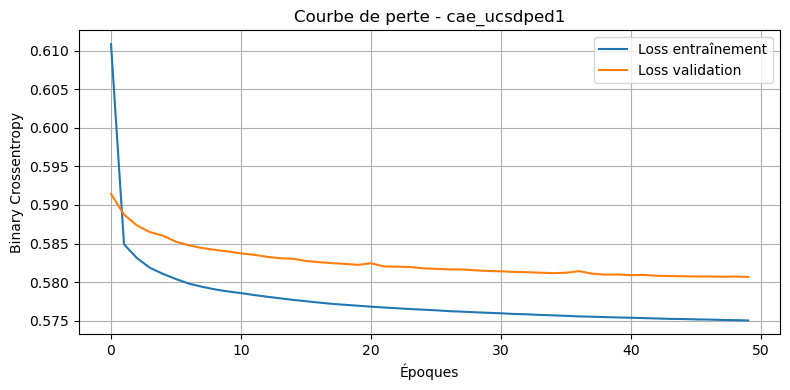

Modèle sauvegardé : cae_ucsdped1.h5
Entraînement CAE sur UCSDped2...
Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 117ms/step - loss: 0.6788 - val_loss: 0.6335
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - loss: 0.6336 - val_loss: 0.6282
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - loss: 0.6294 - val_loss: 0.6264
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - loss: 0.6277 - val_loss: 0.6254
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - loss: 0.6270 - val_loss: 0.6250
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - loss: 0.6265 - val_loss: 0.6246
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - loss: 0.6262 - val_loss: 0.6244
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step - loss: 0.6260 - val_loss: 0.6242
Epoch 9/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - loss: 0.6258 - val_loss: 0.6241
Epoch 10/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - loss: 0.6256 - val_loss: 0.6240
Epoch 11/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - loss: 0.6255 - 

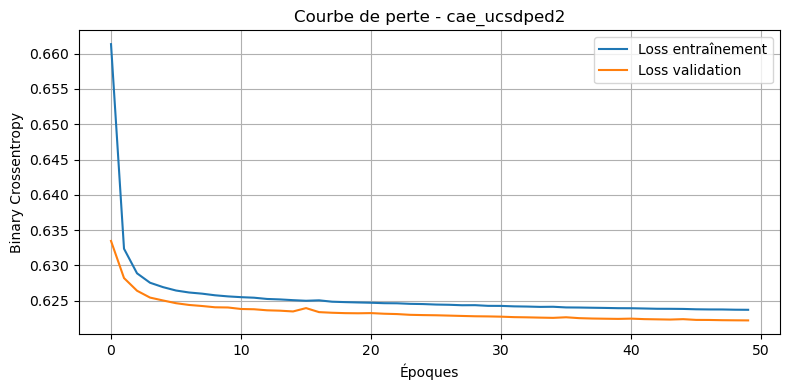

Modèle sauvegardé : cae_ucsdped2.h5


225/225 ━━━━━━━━━━━━━━━━━━━━ 14s 53ms/step
=== Résultats UCSDped1 ===
Seuil automatique: 0.0435
Images test: 7200
Anomalies détectées: 40
Images normales: 7160



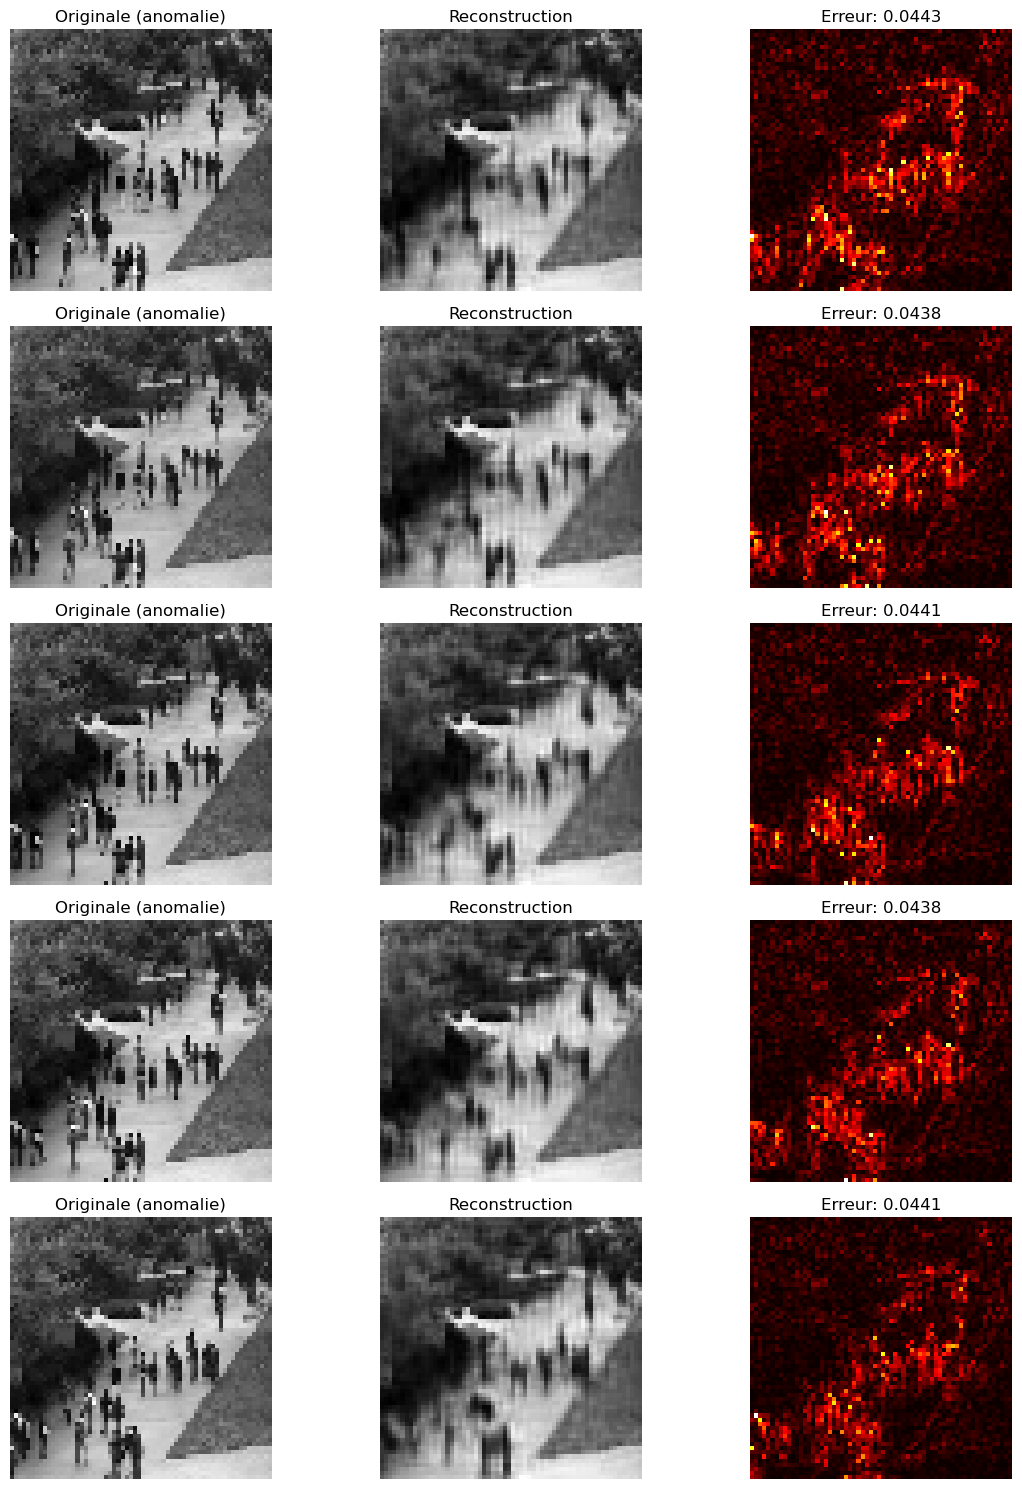

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step
=== Résultats UCSDped2 ===
Seuil automatique: 0.0334
Images test: 2010
Anomalies détectées: 0
Images normales: 2010

Aucune anomalie détectée à afficher.
Visualisation reconstruction UCSDped1
225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step


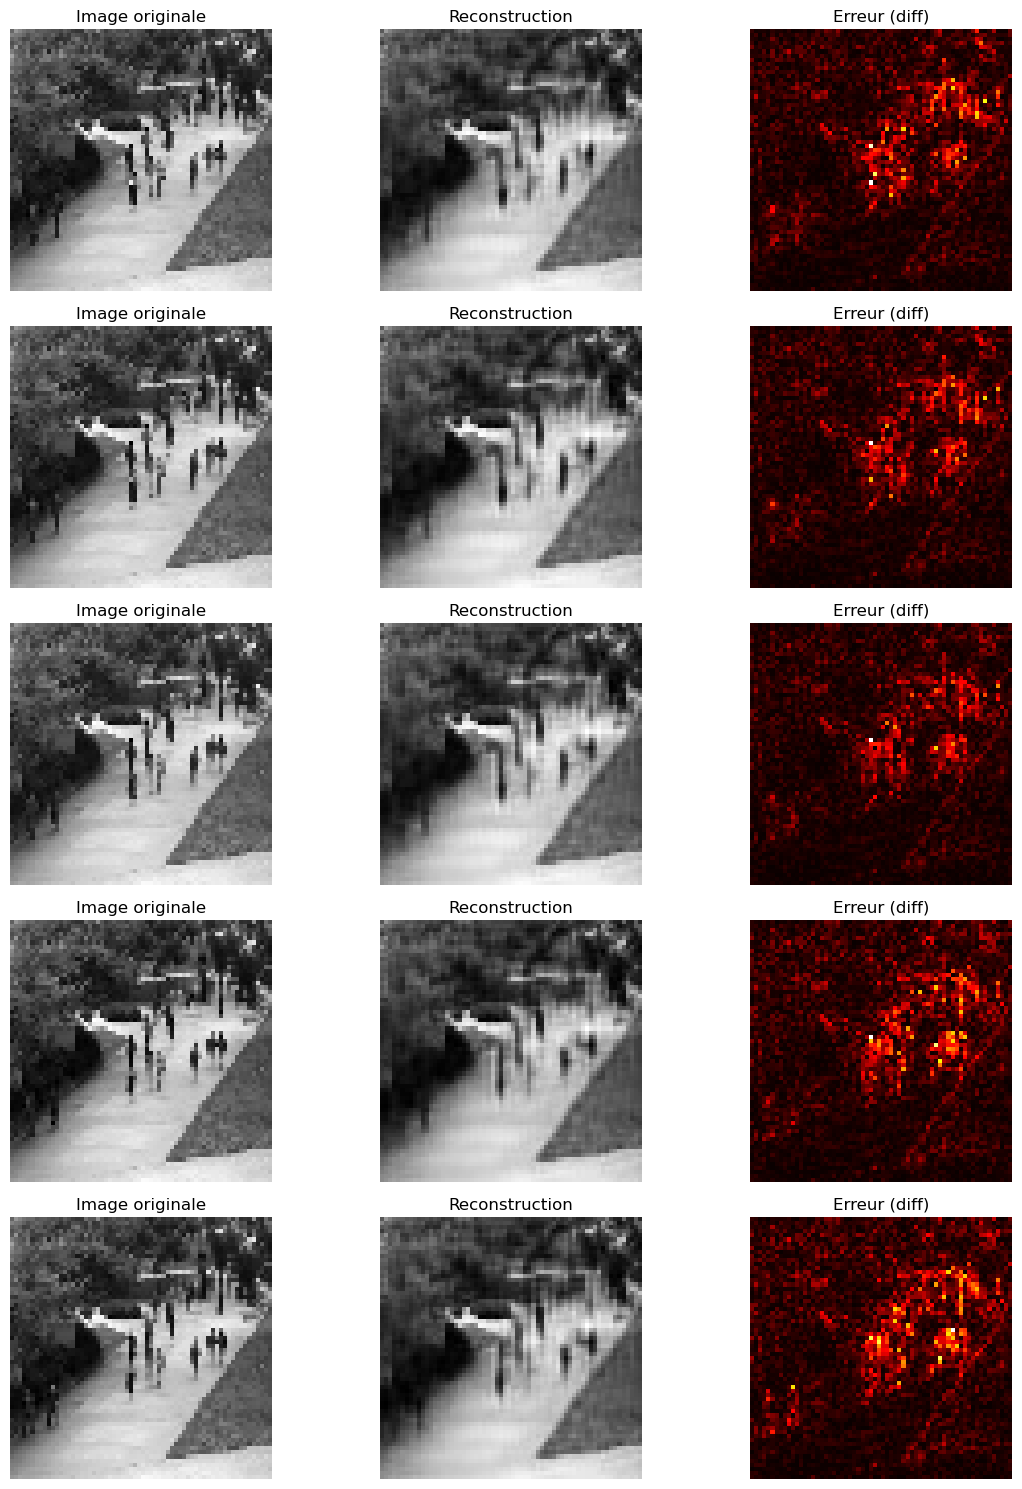

Visualisation reconstruction UCSDped2
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step


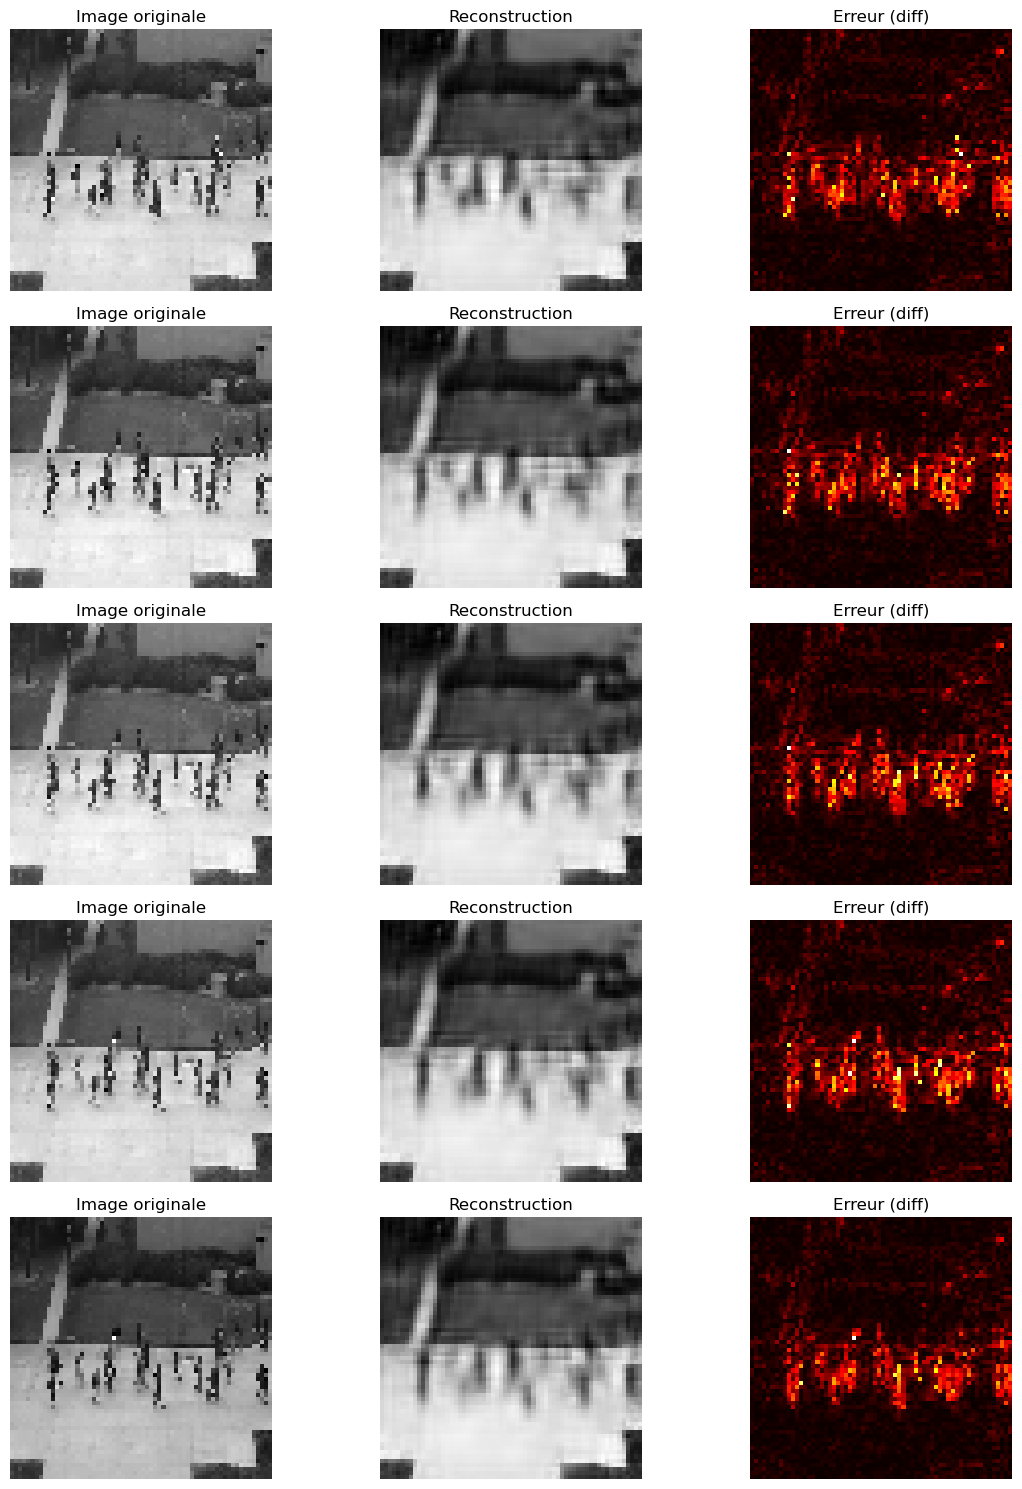

Résumé final des résultats :
{'dataset': 'UCSDped1', 'total': 7200, 'anomalies': 40, 'normales': 7160, 'threshold': 0.04350896365940571}
{'dataset': 'UCSDped2', 'total': 2010, 'anomalies': 0, 'normales': 2010, 'threshold': 0.033394830068573356}


In [34]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


def create_autoencoder():
    input_img = Input(shape=(64, 64, 1))
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)

    x = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer=Adam(1e-3), loss='binary_crossentropy')
    return autoencoder


def train_autoencoder(X_train, model_name):
    model = create_autoencoder()
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(
        X_train, X_train,
        epochs=50,
        batch_size=64,
        validation_split=0.1,
        shuffle=True,
        callbacks=[early_stop]
    )

    # 📈 Affichage courbe de perte
    plt.figure(figsize=(8, 4))
    plt.plot(history.history['loss'], label='Loss entraînement')
    plt.plot(history.history['val_loss'], label='Loss validation')
    plt.xlabel('Époques')
    plt.ylabel('Binary Crossentropy')
    plt.title(f"Courbe de perte - {model_name}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    model.save(model_name + ".h5")
    print(f"Modèle sauvegardé : {model_name}.h5")
    return model


def test_and_detect(model_path, X_test, dataset_name):
    model = load_model(model_path)
    X_recon = model.predict(X_test)
    reconstruction_error = np.mean(np.abs(X_test - X_recon), axis=(1, 2, 3))

    mean_err = np.mean(reconstruction_error)
    std_err = np.std(reconstruction_error)
    threshold = mean_err + 3 * std_err

    pred_labels = (reconstruction_error > threshold).astype(int)

    total = len(X_test)
    anomalies = int(pred_labels.sum())
    normales = int(total - anomalies)

    print(f"=== Résultats {dataset_name} ===")
    print(f"Seuil automatique: {threshold:.4f}")
    print(f"Images test: {total}")
    print(f"Anomalies détectées: {anomalies}")
    print(f"Images normales: {normales}\n")

    # 🔎 Affichage des anomalies détectées uniquement
    anomaly_indices = np.where(pred_labels == 1)[0]
    n = min(5, len(anomaly_indices))

    if n == 0:
        print("Aucune anomalie détectée à afficher.")
    else:
        plt.figure(figsize=(12, n * 3))
        for i in range(n):
            idx = anomaly_indices[i]
            plt.subplot(n, 3, i * 3 + 1)
            plt.imshow(X_test[idx].squeeze(), cmap='gray')
            plt.title("Originale (anomalie)")
            plt.axis('off')

            plt.subplot(n, 3, i * 3 + 2)
            plt.imshow(X_recon[idx].squeeze(), cmap='gray')
            plt.title("Reconstruction")
            plt.axis('off')

            plt.subplot(n, 3, i * 3 + 3)
            diff = np.abs(X_test[idx] - X_recon[idx])
            plt.imshow(diff.squeeze(), cmap='hot')
            plt.title(f"Erreur: {reconstruction_error[idx]:.4f}")
            plt.axis('off')
        plt.tight_layout()
        plt.show()

    return {
        "dataset": dataset_name,
        "total": total,
        "anomalies": anomalies,
        "normales": normales,
        "threshold": float(threshold)
    }


def visualiser_exemple_CAE(model, X_test, nb_images=5):
    X_recon = model.predict(X_test)
    plt.figure(figsize=(12, nb_images * 3))

    for i in range(nb_images):
        plt.subplot(nb_images, 3, i * 3 + 1)
        plt.imshow(X_test[i].squeeze(), cmap='gray')
        plt.title("Image originale")
        plt.axis('off')

        plt.subplot(nb_images, 3, i * 3 + 2)
        plt.imshow(X_recon[i].squeeze(), cmap='gray')
        plt.title("Reconstruction")
        plt.axis('off')

        plt.subplot(nb_images, 3, i * 3 + 3)
        diff = np.abs(X_test[i] - X_recon[i])
        plt.imshow(diff.squeeze(), cmap='hot')
        plt.title("Erreur (diff)")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# === Chargement des données ===
X_train_ped1 = np.load("UCSDped1_train.npy").reshape(-1, 64, 64, 1)
X_test_ped1 = np.load("UCSDped1_test.npy").reshape(-1, 64, 64, 1)

X_train_ped2 = np.load("UCSDped2_train.npy").reshape(-1, 64, 64, 1)
X_test_ped2 = np.load("UCSDped2_test.npy").reshape(-1, 64, 64, 1)

# === Entraînement ===
print("Entraînement CAE sur UCSDped1...")
model_ped1 = train_autoencoder(X_train_ped1, "cae_ucsdped1")

print("Entraînement CAE sur UCSDped2...")
model_ped2 = train_autoencoder(X_train_ped2, "cae_ucsdped2")

# === Test & Anomalies ===
stats_ped1 = test_and_detect("cae_ucsdped1.h5", X_test_ped1, "UCSDped1")
stats_ped2 = test_and_detect("cae_ucsdped2.h5", X_test_ped2, "UCSDped2")

# === Visualisation du fonctionnement du CAE ===
print("Visualisation reconstruction UCSDped1")
visualiser_exemple_CAE(model_ped1, X_test_ped1)

print("Visualisation reconstruction UCSDped2")
visualiser_exemple_CAE(model_ped2, X_test_ped2)

print("Résumé final des résultats :")
print(stats_ped1)
print(stats_ped2)
